## Fuzzy Inference in Python

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# Set the LaTeX font style and ensure text rendering uses LaTeX
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Define the maroon/purple color for the lines
line_color = '#4B0082'


In [74]:
def piecewise_linear_sigmoid(x_uod: np.ndarray, midpoint: float, width: float, height: float) -> np.ndarray:
    """Piecewise linear approximation of a sigmoid function.
    
    Args:
        x_uod (np.ndarray): Universe of discourse (x-axis; independent variable).
        midpoint (float): The x-value at which the sigmoid reaches its midpoint.
        width (float): The width of the transition region.
        height (float): The height of the sigmoid function (typically 1.0).
    
    Returns:
        y (np.ndarray): 1-D piecewise linear sigmoid function.
    """
    y = np.zeros(len(x_uod), dtype=float)
    
    # First section: y = 0
    idx = np.nonzero(x_uod < (midpoint - width / 2))[0]
    y[idx] = 0
    
    # Second section: slope
    idx = np.nonzero((x_uod >= (midpoint - width / 2)) & (x_uod <= (midpoint + width / 2)))[0]
    y[idx] = height * (x_uod[idx] - (midpoint - width / 2)) / width
    
    # Third section: y = height
    idx = np.nonzero(x_uod > (midpoint + width / 2))[0]
    y[idx] = height
    
    return y

In [75]:
# generate membership function shapes with these 5 funcs I like 
# (singletons, step, sigmoid, trapezoidal, piecewise linear sigmoid, triangular)

def trapz_function(x_uod: np.ndarray, m_lower: float, m_upper: float, 
                    alpha: float, beta: float, 
                    height: float) -> np.ndarray:
    """Trapezoidal membership function generator. 
    
    Based on p59, Dubois and Prade, 1988, Possibility Theory.
    Adapted from scikit-fuzzy package.
    Use of quintuple (i.e., five input parameters) allows a max height other than 1.0.
    
    TODO: 
    * Add kwargs catch-all for other quintuples for union of trapezoids (e.g., bimodal with gap in middle)
    
    Args:
        x_uod (np.ndarray): Universe of discourse (x-axis; independent variable).
        m_lower (float): Lower "modal value" of the trapezium. Left side of trapezium core.
        m_upper (float): Upper "modal value" of the trapezium. Right side of trapezium core.
        alpha (float): Lower "spread" of the trapezium (difference in x between limit and core edge).
        beta (float): Upper "spread" of the trapezium (as alpha but for right side).
        height (float): Height of the trapezium. Typically is 1.0 but we may use non-normalized values.
    
    Returns:
        y (np.ndarray): 1-D trapezoidal membership function.
    """
    # Check ordering of the arguments 
    assert m_lower <= m_upper, "m_lower must be < or = m_upper."
    assert alpha >= 0, "alpha must be greater than or equal to 0."
    assert beta >= 0, "beta must be greater than or equal to 0."
    assert 0 < height <= 1, "height must be > 0 and less or equal to 1."
    
    y = np.zeros(len(x_uod), dtype=float)
    
    # IN THE CASE OF A SINGLETON
    # if m_lower == m_upper, and alpha == beta == 0, then this is a singleton
    # Located at m_lower (or m_upper) value
    if m_lower == m_upper and alpha == beta == 0:
        idx = np.nonzero(x_uod == m_lower)[0]
        y[idx] = height
        # TODO - if plotted, this should be a delta function
        return y

    # First section: zeros already in y
    pass
    
    # Second section: lower slope
    # idx = np.nonzero(x_uod >= m_lower - alpha)[0]
    idx = np.nonzero((x_uod >= m_lower - alpha) & (x_uod < m_lower))[0]
    y[idx] = height * (x_uod[idx] - (m_lower - alpha)) / alpha

    # Third section: flat top
    idx = np.nonzero((x_uod >= m_lower) & (x_uod <= m_upper))[0]
    y[idx] = height
    
    # Fourth section: upper slope
    # Upper slope
    idx = np.nonzero((x_uod > m_upper) & (x_uod <= m_upper + beta))[0]
    y[idx] = height * (m_upper + beta - x_uod[idx]) / beta    
    # idx = np.nonzero(x_uod <= m_upper + beta)[0]
    # y[idx] = (m_upper + beta - x_uod[idx]) / beta
    
    # Fifth section: zeros already in y
    pass

    return y

In [76]:
def plot_step(ax,jump_x=7.5):
    x = np.linspace(0, 15, 100)
    # y = np.zeros_like(x)
    y = np.piecewise(x, [x < jump_x, x >= jump_x], [lambda x: 0.0, lambda x: 1.0])

    # ax.plot(x, y, color=line_color, linewidth=2)
    ax.plot(x[x < jump_x], y[x < jump_x], color=line_color, linewidth=2)
    ax.plot(x[x >= jump_x], y[x >= jump_x], color=line_color, linewidth=2)

    ax.axvline(x=7.5, color=line_color, linestyle='--', alpha=0.6)
    
    ax.set_title(r'\textbf{Step function for deep snow cover}', fontsize=14)
    ax.set_xlabel(r'\textbf{Snow depth (cm)}', fontsize=12)
    ax.set_ylabel(r'\textbf{Degree of membership $\mu$}', fontsize=12)
    ax.set_ylim(-0.2, 1.2)
    ax.set_xlim(5, 10)
    ax.axhline(y=1, color='grey', linestyle='--', alpha=0.6)
    ax.axhline(y=0, color='grey', linestyle='--', alpha=0.6)
    ax.text(8.5, 0.8, r'\textbf{True}', fontsize=10, verticalalignment='center')
    ax.text(6.0, 0.2, r'\textbf{False}', fontsize=10, verticalalignment='center')
    ax.grid(False)

def plot_sigmoid(ax):
    x = np.linspace(0, 15, 100)
    y = 1 / (1 + np.exp(-(x - 7.5)))
    ax.plot(x, y, color=line_color, linewidth=2)
    
    # To differentiate from a zeroth-order discontinuity above, we 
    # add a vertical line at zero as black
    ax.axvline(x=7.5, color="black", linestyle='--', alpha=0.6)
    
    ax.set_title(r'\textbf{Sigmoid function for deep snow cover}', fontsize=14)
    ax.set_xlabel(r'\textbf{Snow depth (cm)}', fontsize=12)
    ax.set_ylabel(r'\textbf{Degree of membership $\mu$}', fontsize=12)
    ax.set_ylim(-0.2, 1.2)
    ax.set_xlim(0, 15)
    ax.axhline(y=1, color='grey', linestyle='--', alpha=0.6)
    ax.axhline(y=0, color='grey', linestyle='--', alpha=0.6)
    ax.text(8.3, 0.55, r'More plausibly true $\longrightarrow$', fontsize=10, verticalalignment='center', multialignment='center')
    ax.text(1.0, 0.45, r'$\longleftarrow$ Less plausibly true', fontsize=10, verticalalignment='center', multialignment='center')
    ax.grid(False)

def make_binary_figure(shapes=["step", "sigmoid"]):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    plot_functions = {
        "step": plot_step,
        "sigmoid": plot_sigmoid
    }

    for ax, shape in zip(axes, shapes):
        plot_functions[shape](ax)

    return fig, axes

In [77]:
def plot_mf(ax, x, y, label=None, line_color="magenta", **kwargs):
    """Plot a membership function on a given axis.
    
    Args:
        ax (matplotlib.axes.Axes): The axis to plot the membership function on.
        x (np.ndarray): The universe of discourse (x-axis).
        y (np.ndarray): The membership function values (y-axis).
        label (str): The label for the membership function.
        line_color (str): The color of the line.
        **kwargs: Additional keyword arguments to pass to matplotlib plot function.
        
    Returns:
        ax (matplotlib.axes.Axes): The axis with the membership function plotted.
    
    """
    # Remove top and right spines of axis
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # Check if there's only one non-zero value in y
    # TODO - if any vertical lines (right-angle triangle) this should also have a delta function
    if np.count_nonzero(y) == 1:
        idx = np.nonzero(y)[0]
        ax.axvline(x=x[idx], color=line_color, linestyle='--', alpha=0.6)
        ax.set_xlim(x[0], x[-1])
        # Add a large circle at the value of y to show the limit 
        # Plot over the axes lines so it is clear
        ax.plot(x[idx], y[idx], 'o', color=line_color, markersize=10, 
                    zorder=10, label='Singleton', **kwargs)   
    else:
        ax.plot(x, y, color=line_color, linewidth=2, label=label,
                    **kwargs)
    ax.set_ylim(-0.01,1.01)
    ax.legend()
    return ax 

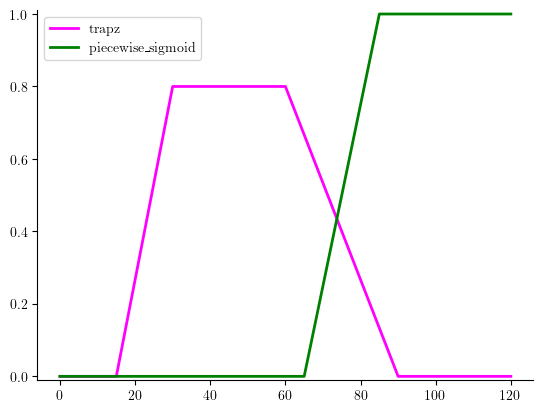

In [78]:
# Do a one-panel plot for showing the two functions we like.
# piecewise linear sigmoid (p.l.s.) and trapezoidal
mf_shapes = {
    "trapz": "magenta",
    "piecewise_sigmoid": "green"
}

def make_mf_figure(shapes, plot_union=False, plot_intersection=False):
    fig, ax = plt.subplots(1)
    x_uod = np.arange(0, 121, 1)
    ys = []
    # Show the two shapes individually labelled
    for shape, color in shapes.items():
        if shape == "trapz":
            y1 = trapz_function(x_uod, 30, 60, 15, 30, 0.8)
        elif shape == "piecewise_sigmoid":
            y1 = piecewise_linear_sigmoid(x_uod, 75, 20, 1.0)
        plot_mf(ax, x_uod, y1, label=shape, line_color=color)
        ys.append(y1)

    # Correct union and intersection computations
    y_union = np.maximum.reduce(ys)  # Corrected np.maximum application
    y_intersection = np.minimum.reduce(ys)  # Corrected np.minimum application
    
    # Fill under the union curve
    if plot_union:
        ax = plot_mf(ax, x_uod, y_union, label="Union", line_color="black", linestyle='--')
        ax.fill_between(x_uod, 0, y_union, alpha=0.3, color="black")  # Fill under the union curve
    
    # Fill under the intersection curve
    if plot_intersection:
        ax = plot_mf(ax, x_uod, y_intersection, label="Intersection", line_color="black", linestyle='--')
        ax.fill_between(x_uod, 0, y_intersection, alpha=0.3, color="black")  # Fill under the intersection curve
    
    return fig, ax

fig, ax = make_mf_figure(mf_shapes)
plt.show()

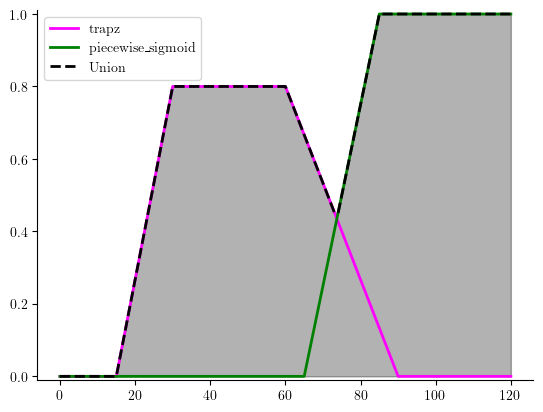

In [79]:
fig, ax = make_mf_figure(mf_shapes, plot_union=True)
plt.show()

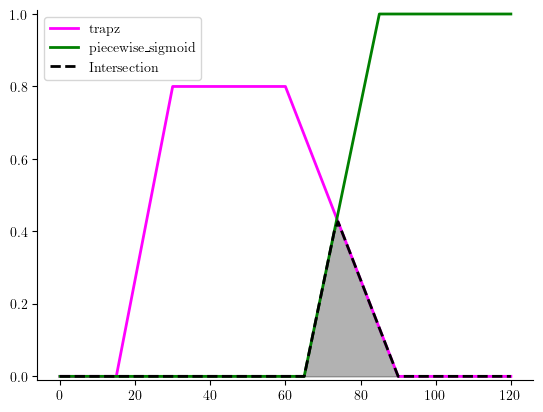

In [80]:
fig, ax = make_mf_figure(mf_shapes, plot_intersection=True)
plt.show()

In [81]:
# Test the trapezoidal function 
# M quintuple p59 in Dubois and Prade has the meaning as:
# M = (m_lower, m_upper, alpha, beta, height) - refer to docstring for trapz_function

# Universe of discourse, or x-axis range and quantization/resolution
x_uod = np.arange(0,121,1)

# To test four examples on p58 (without the union singletons for simplicity):
sources = {}

# source A: singleton
sources["A"] = (100, 100, 0, 0, 1) 

# source B: trapezoid
sources["B"] = (50,70,10,30,0.9)

# source C: top hat 
sources["C"] = (100,110,0,0,1)

# source D: right-angled triangle
sources["D"] = (20, 20, 0, 10, 0.8)

# This isn't in book, but a symmetrical triangle function for source E.
sources["E"] = (60, 60, 20, 20, 0.5)

# This isn't in book, but piecewise linear sigmoid for source F.
# This needs only 3 parameters: midpoint, width, height
sources["F"] = (50,20, 0.88)




/var/folders/rr/m6rsyqmd64q6ddlcqfq1sng00000gp/T/ipykernel_34500/3356871703.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


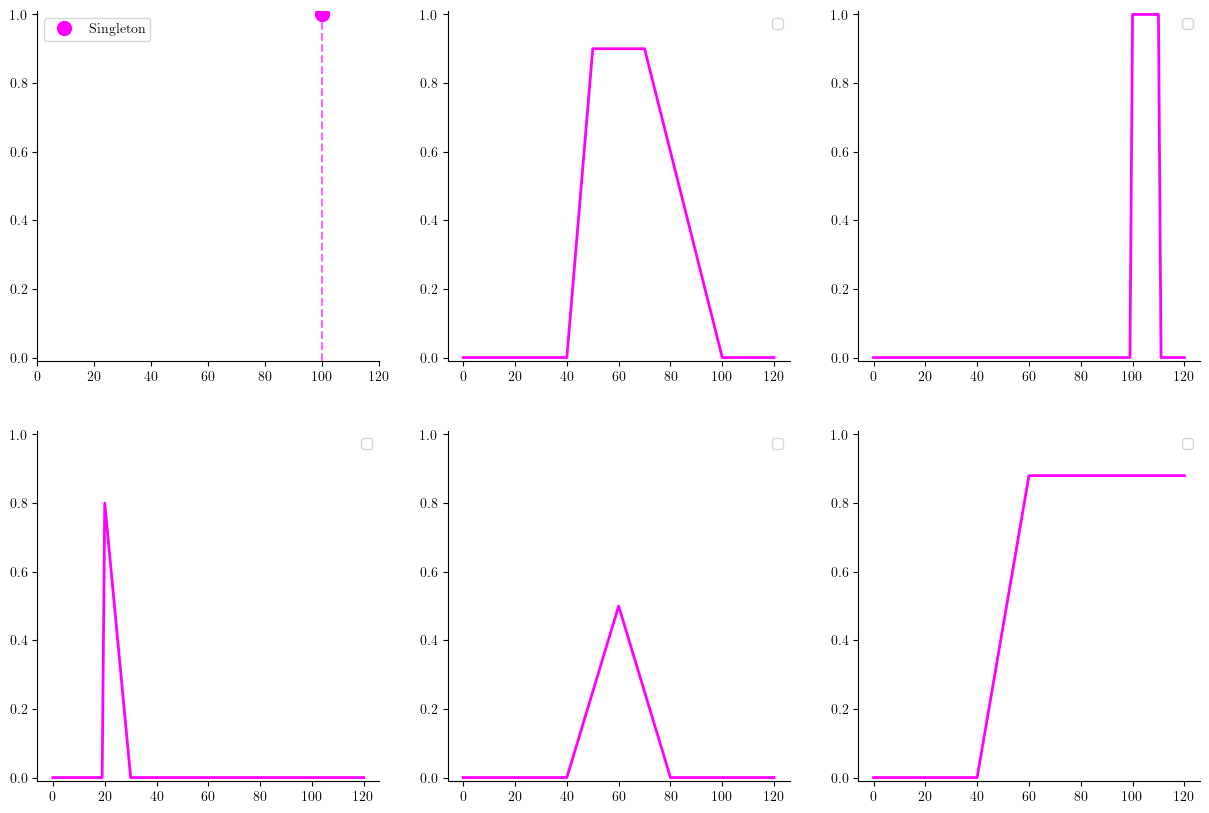

In [82]:
# Plot all five on a 2-row, 3-column subplot figure
fig, _axes = plt.subplots(2, 3, figsize=(15, 10))
axes = iter(_axes.flatten())

for M in sources.keys():
    ax = next(axes)
    if M == "F":
        y = piecewise_linear_sigmoid(x_uod, *sources[M])
    else:
        y = trapz_function(x_uod, *sources[M],)
    plot_mf(ax, x_uod, y)

plt.show()

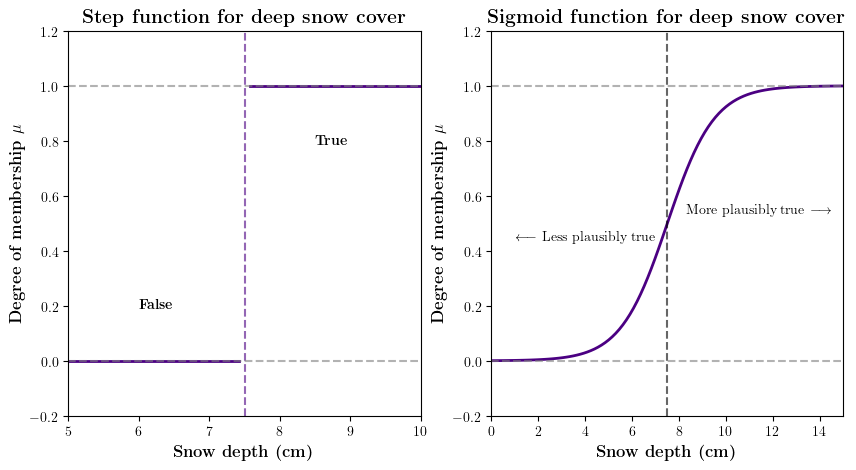

In [83]:
# Show the difference between binary and fuzzy logic
fig, axes = make_binary_figure(["step", "sigmoid"])
plt.show()

The two membership function shapes we use will be trapzoidal (piecewise linear Gaussian curves, kind-of) and piecewise linear sigmoids.

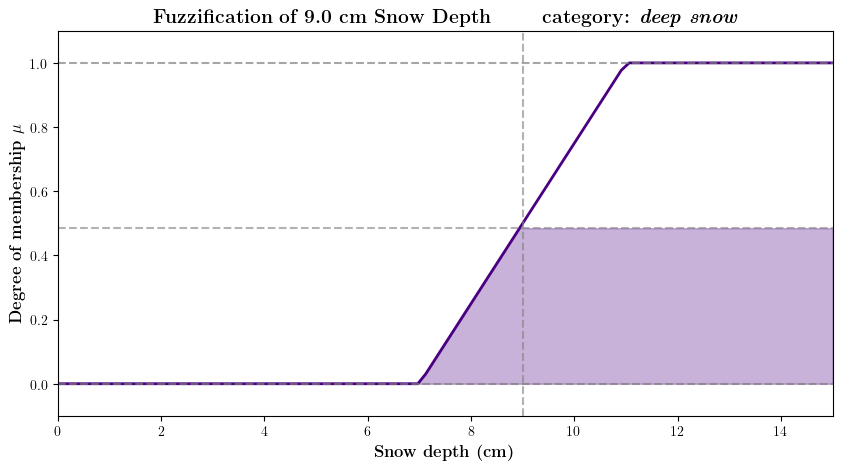

In [95]:
def plot_fuzzification(mf_shape="pl_sigmoid", x_value: float=9.0):
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(10, 5))

    # Membership function data for fuzzy "deep snow cover"
    x = np.linspace(0, 15, 100)
    
    if mf_shape == "pl_sigmoid":
        y = piecewise_linear_sigmoid(x, x_value, 4, 1.0)
    elif mf_shape == "trapz":
        y = trapz_function(x, 5, 10, 2, 2, 0.9)
    else:
        raise ValueError(f"Unknown membership function shape: {mf_shape}")

    # Plot the membership function
    ax.plot(x, y, color=line_color, linewidth=2)
    
    # Vertical line at looked up value
    ax.axvline(x=x_value, color='grey', linestyle='--', alpha=0.6)  
    
    y_at_intersection = y[np.argmin(np.abs(x - x_value))]
    ax.axhline(y=y_at_intersection, color='grey', linestyle='--', alpha=0.6)  # Horizontal grey line at y corresponding to x=9

    # Create a combined y-array for filling
    y_combined = np.where(x <= x_value, y, y_at_intersection)

    # Fill the area under the membership function curve
    ax.fill_between(x, 0, y_combined, color=line_color, alpha=0.3)


    # Set titles and labels
    ax.set_title(rf'\textbf{{Fuzzification of {x_value} cm Snow Depth \qquad category: \textit{{deep snow}}}}', fontsize=14)
    ax.set_xlabel(r'\textbf{Snow depth (cm)}', fontsize=12)
    ax.set_ylabel(r'\textbf{Degree of membership $\mu$}', fontsize=12)
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(0, 15)
    ax.axhline(y=1, color='grey', linestyle='--', alpha=0.7)
    ax.axhline(y=0, color='grey', linestyle='--', alpha=0.7)
    ax.grid(False)

    return fig, ax

fig, ax = plot_fuzzification(mf_shape="pl_sigmoid")
plt.show()

## Maths of Fuzzy Inference: supremum and infimum, OR, AND, etc
More about the maths here, and how we join criteria (AND = min) then aggregated rules (OR = max = possibility)

We'll have a rule that says if snow is deep and pressure is high, then ozone is elevated.
We will only define membership function for these three variables and categories as an example

Then we fuzzify for the values of pressure = 1040 hPa, snow = 9cm, and establish the degree of membership for ozone.

In [86]:
# 